Joan Carles Montero
# Machine Learning-Based Classification of Skin Lesions
### LOCAL 7-class classification

In [1]:
from PIL import Image
import os
import numpy as np
import pandas as pd

# Definine directory path
images_path = "data/images/"
masks_path = "data/masks/"
# Paths to the data
metadata_path = 'data/metadata.csv'
# Loading the data
metadata = pd.read_csv(metadata_path)
print(metadata.head())

          image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ISIC_0024306  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1  ISIC_0024307  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2  ISIC_0024308  0.0  1.0  0.0    0.0  0.0  0.0   0.0
3  ISIC_0024309  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4  ISIC_0024310  1.0  0.0  0.0    0.0  0.0  0.0   0.0


In [2]:
# Checking if each row has exactly one instance of 1.0 across the columns of interest
unique_one_per_row = metadata.iloc[:, 1:].apply(lambda row: (row == 1.0).sum(), axis=1) == 1
all_rows_have_unique_one = unique_one_per_row.all()
print(all_rows_have_unique_one)

# Checking number of images (rows)
print(len(metadata))

# Checking number of nans generally
any_nans = metadata.isna().any().any()
print(any_nans)

True
10015
False


In [3]:
# Some basic data exploration
directory_path = "data/images"

image_path = os.path.join(directory_path, "ISIC_0024306.jpg")

# Open the image file
with Image.open(image_path) as img:
    # Get the size of the image
    size = img.size

# Cheking the images size
print(size) # (600, 450)

# Getting the number of files in images
num_files = len([name for name in os.listdir(directory_path)
                 if os.path.isfile(os.path.join(directory_path, name))])
print(num_files) # 10015 + LICENSE.txt + ATTRIBUTION.txt

(600, 450)
10017


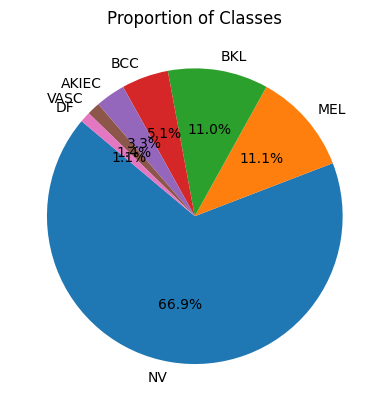

In [52]:
import matplotlib.pyplot as plt

# Summing up the occurrences of each class
class_counts = metadata.iloc[:, 1:].sum().sort_values(ascending=False)

# Plotting a pie chart
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Proportion of Classes')
plt.show()

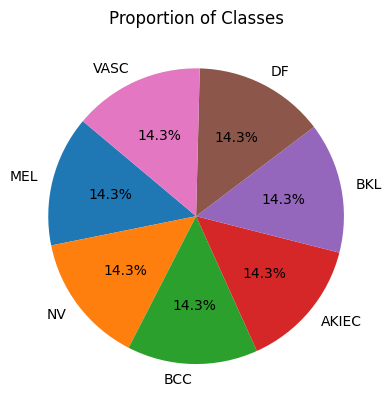

In [54]:
# Code to balance the dataset

# Create a single label column that contains the class with the highest value
metadata['label'] = metadata[['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']].idxmax(axis=1)

# Calculate the number of samples per class for a balanced subset
number_images = 1001
samples_per_class = number_images // len(metadata['label'].unique()) # So that we get 143 image for each class

selected_indexes = []
# Iterating over each label
for label, group in metadata.groupby('label'):
    #print(f"Label: {label}, Length: {len(group)}")
    if len(group)>=samples_per_class:
        # If there are enough images we'll pick samples_per_class samples
        selected_indexes.extend(group.sample(n=samples_per_class, random_state=33).index.tolist())
    else:
        # If there are not enough, we'll have to repeat them 
        selected_indexes.extend(group.sample(n=samples_per_class, replace = True, random_state=33).index.tolist())
sample_metadata = metadata.loc[selected_indexes]

# Summing up the occurrences of each class
class_counts = sample_metadata.iloc[:, 1:-1].sum().sort_values(ascending=False)

# Plotting a pie chart
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Proportion of Classes')
plt.show()

In [19]:
# Code to load the images and masks as numpy objects
from tqdm import tqdm
image_data = []
image_cleaned = []
labels = []

# Loop through the sampled metadata to load images and labels
for _, row in tqdm(sample_metadata.iterrows(), total = number_images):
    img_path = os.path.join(images_path, row['image']+".jpg")
    img = Image.open(img_path)
    img = img.resize((300,225))
    img_array = np.array(img)
    
    image_data.append(img_array)
    labels.append(row[1:-1]) # Only saving the one hot encoded labels
    
    mask_path = os.path.join(masks_path, row['image']+".png")
    mask = Image.open(mask_path)
    mask = mask.resize((300, 225))
    mask_array = np.array(mask)

    mask_array = np.where(np.array(mask) == 255, 1, 0)

    focused_img_array = img_array * mask_array[:, :, None] #(height, width, none), to turn the grayscale mask 2D into 3D

    image_cleaned.append(focused_img_array)

# Convert lists to NumPy arrays
image_cleaned = np.array(image_cleaned, dtype=np.uint8)
image_data = np.array(image_data, dtype=np.uint8)
labels = np.array(labels)
print(image_cleaned.shape)
print(image_data.shape)
print(labels.shape)

100%|██████████████████████████████████████████████████████████████████████████████| 1001/1001 [00:41<00:00, 24.18it/s]


(1001, 225, 300, 3)
(1001, 225, 300, 3)
(1001, 7)


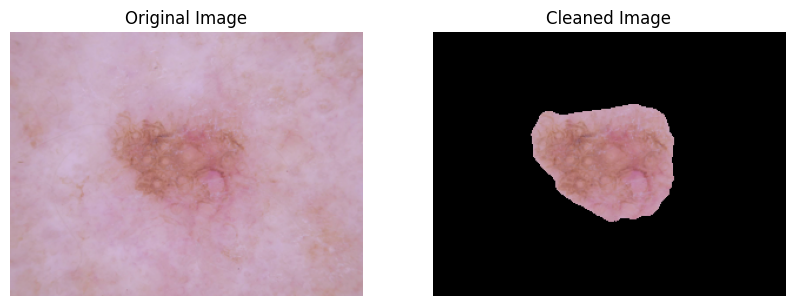

In [20]:
# Example of an image with its mask
i = 100
first_cleaned_image = image_cleaned[i]
first_original_image = image_data[i]

plt.figure(figsize=(10, 5))

# Plot the first original image
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.imshow(first_original_image)
plt.title("Original Image")
plt.axis('off')

# Plot the first "cleaned" image (focusing on the lesion) 
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.imshow(first_cleaned_image)
plt.title("Cleaned Image")
plt.axis('off')

# Display the plots
plt.show()

In [31]:
# Code to reduce the data dimensionality by using KMeans clustering

import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import KMeans

# Function to extract the primary colors using KMeans clustering
def get_primary_colors(image, n_colors=3):
    # Reshape the image to a 2D array of pixels
    pixels = image.reshape(-1, 3) # to resize the image to 2D, now (225 * 300, 3) instead of (225, 300, 3)

    # Remove black/near-black pixels
    pixels = pixels[np.sum(pixels, axis=1) > 10]

    # Apply KMeans clustering to find dominant colors
    kmeans = KMeans(n_clusters=n_colors, n_init = 5)
    kmeans.fit(pixels)

    # Return the cluster centers (dominant colors) and the cluster centroids
    return kmeans.cluster_centers_

def std_dev_primary_colors(primary_colors):
    return np.std(primary_colors, axis=0)

feature_data = []

for image_id, image, label in tqdm(zip(sample_metadata['image'], image_cleaned, sample_metadata['label']), total=number_images):
    
    cluster_centroids = get_primary_colors(image)
    
    # Flatten the  cluster centroids to create a single list of RGB values
    cluster_centroids_flat = cluster_centroids.flatten()
    
    std_dev = std_dev_primary_colors(cluster_centroids)
    
    # Concatenate the primary colors, cluster centroids, and standard deviation
    row = np.concatenate((cluster_centroids_flat, std_dev)).tolist()
    
    row.insert(0, label)
    row.insert(0, image_id)
    
    feature_data.append(row)

# Update column names to include cluster centroids
centroid_columns = ['centroid_r_1', 'centroid_g_1', 'centroid_b_1',
                    'centroid_r_2', 'centroid_g_2', 'centroid_b_2',
                    'centroid_r_3', 'centroid_g_3', 'centroid_b_3']

std_dev_columns = ['std_dev_r', 'std_dev_g', 'std_dev_b']

feature_columns = ['image_id', 'label'] + centroid_columns + std_dev_columns

features_df = pd.DataFrame(feature_data, columns=feature_columns)

print(features_df.head())

100%|██████████████████████████████████████████████████████████████████████████████| 1001/1001 [01:25<00:00, 11.69it/s]

       image_id  label  centroid_r_1  centroid_g_1  centroid_b_1  \
0  ISIC_0029500  AKIEC    174.258960     98.283509    123.284960   
1  ISIC_0032897  AKIEC    197.538835    140.075957    137.249286   
2  ISIC_0024372  AKIEC    200.325202    159.581078    173.311792   
3  ISIC_0030707  AKIEC    193.526756    115.535924    115.519781   
4  ISIC_0032947  AKIEC    210.465947    140.254214    148.997303   

   centroid_r_2  centroid_g_2  centroid_b_2  centroid_r_3  centroid_g_3  \
0    190.778631    125.784754    154.645288    204.231043    149.428971   
1    209.110824    157.318334    157.547887    217.207859    172.203033   
2    217.031636    183.380497    198.652172    179.867226    130.600916   
3    208.094319    146.305952    151.502213    178.091842     84.763482   
4    221.021398    163.485497    174.836900    194.552042    118.113307   

   centroid_b_3  std_dev_r  std_dev_g  std_dev_b  
0    180.575033  41.322214  36.178189  31.169085  
1    177.704585  41.322214  36.178189 

In [32]:
# Data splitting
from sklearn.model_selection import train_test_split

X = features_df.drop(['image_id', 'label'], axis=1)
y = features_df['label']

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [33]:
# Scaling the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit and transform the training data and transform the testing data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

              precision    recall  f1-score   support

       AKIEC       0.48      0.39      0.43        28
         BCC       0.36      0.37      0.36        27
         BKL       0.35      0.27      0.30        30
          DF       0.29      0.27      0.28        26
         MEL       0.53      0.50      0.52        32
          NV       0.53      0.68      0.59        28
        VASC       0.65      0.80      0.72        30

    accuracy                           0.47       201
   macro avg       0.45      0.47      0.46       201
weighted avg       0.46      0.47      0.46       201

One-vs-Rest Confusion Matrix:


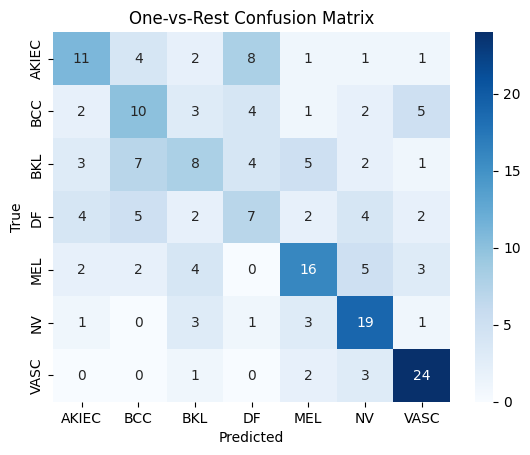

In [34]:
# From now on, training and testing the models
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Create the One-vs-Rest classifier
ovr_classifier = OneVsRestClassifier(LogisticRegression(random_state=42))

# Training the classifier
ovr_classifier.fit(X_train, y_train)

# Predictions
y_pred = ovr_classifier.predict(X_test)

# Evaluate the classifier
print(classification_report(y_test, y_pred)) # Better recall than CNN: BKL, DF, NV, VASC

# Get class names
class_names = y.unique()

# Confusion matrix for OvR classifier
cm_ovr = confusion_matrix(y_test, y_pred, labels=class_names)
print("One-vs-Rest Confusion Matrix:")

# Visualizing the confusion matrix
sns.heatmap(cm_ovr, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('One-vs-Rest Confusion Matrix')
#plt.show()
plt.savefig('ovr.png')

              precision    recall  f1-score   support

       AKIEC       0.41      0.32      0.36        28
         BCC       0.27      0.33      0.30        27
         BKL       0.32      0.30      0.31        30
          DF       0.32      0.27      0.29        26
         MEL       0.48      0.41      0.44        32
          NV       0.54      0.68      0.60        28
        VASC       0.74      0.83      0.78        30

    accuracy                           0.45       201
   macro avg       0.44      0.45      0.44       201
weighted avg       0.44      0.45      0.45       201



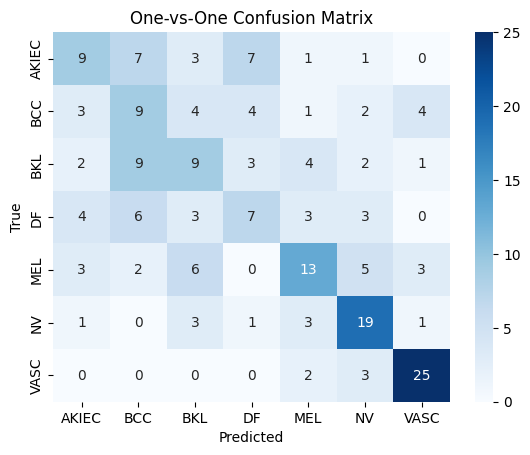

In [35]:
from sklearn.multiclass import OneVsOneClassifier

# Create the One-vs-One classifier
ovo_classifier = OneVsOneClassifier(LogisticRegression(random_state=42))

# Training the classifier
ovo_classifier.fit(X_train, y_train)

# Predictions
y_pred_ovo = ovo_classifier.predict(X_test)

# Evaluate the classifier
print(classification_report(y_test, y_pred_ovo)) # Better recall: BKL and VASC

# Confusion matrix for OvO classifier
cm_ovo = confusion_matrix(y_test, y_pred_ovo, labels=class_names)

# Visualizing the confusion matrix
sns.heatmap(cm_ovo, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('One-vs-One Confusion Matrix')
plt.show()

              precision    recall  f1-score   support

       AKIEC       0.35      0.39      0.37        28
         BCC       0.45      0.52      0.48        27
         BKL       0.26      0.30      0.28        30
          DF       0.48      0.42      0.45        26
         MEL       0.48      0.34      0.40        32
          NV       0.61      0.61      0.61        28
        VASC       0.84      0.87      0.85        30

    accuracy                           0.49       201
   macro avg       0.50      0.49      0.49       201
weighted avg       0.50      0.49      0.49       201



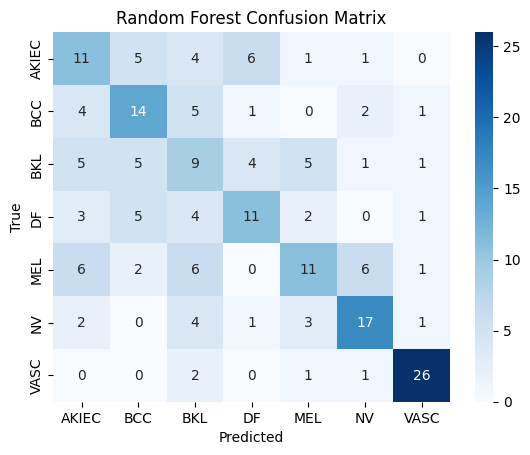

In [36]:
from sklearn.ensemble import RandomForestClassifier

# Train the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

# Make Predictions
y_pred_rf = rf_classifier.predict(X_test)

# Generate Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=class_names)

# Print Classification Report
print(classification_report(y_test, y_pred_rf))

# Visualize Confusion Matrix
sns.heatmap(cm_rf, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Random Forest Confusion Matrix')
plt.show()

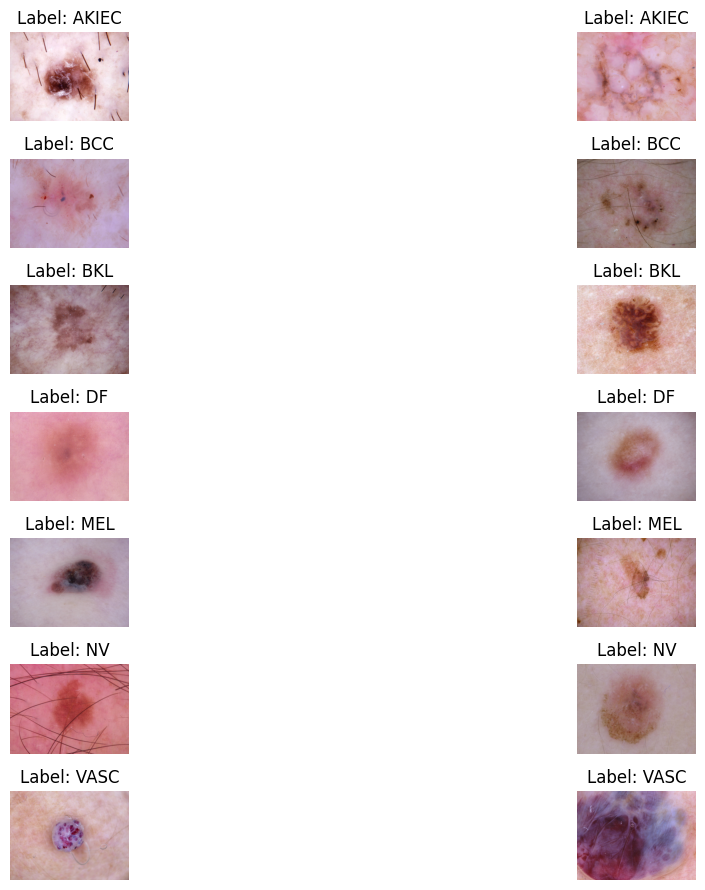

In [37]:
# Code to print a sample of images from each class
from PIL import Image

image_ids = []

fig, axs = plt.subplots(nrows=sample_metadata['label'].nunique(), ncols=2, figsize=(16, 9))

for (i, (label, group)) in enumerate(sample_metadata.groupby('label')): # goupby returns a pair of label, the key, and the subset of the dataframe
    for (j, (index, row)) in enumerate(group.sample(n=2, random_state=42).iterrows()): # get two samples of each label to show
        img_path = os.path.join(images_path, row['image'] + '.jpg')
        img = Image.open(img_path)
        ax = axs[i, j]
        ax.imshow(img)
        ax.set_title(f'Label: {label}')
        ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Code to create a folder for each unique label and copy the images into it

import os
import shutil

# Directory where the folders will be created
output_dir = 'data/'

# Create a folder for each unique label
for label in sample_metadata['label'].unique():
    folder_path = os.path.join(output_dir, label)
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

# Copy each image to the corresponding folder
for index, row in sample_metadata.iterrows():
    src_path = os.path.join(images_path, row['image'] + '.jpg')
    dst_path = os.path.join(output_dir, row['label'], row['image'] + '.jpg')
    shutil.copy(src_path, dst_path)

In [28]:
# Save the data
np.save("images.npy", image_data)
np.save("images_filtered.npy", image_cleaned)
np.save("labels.npy", labels)

In [ ]:
# Code to upload the numpy objects to Google Drive
from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
import os
import pickle

# The SCOPES are the permissions the application will ask for.
SCOPES = ['https://www.googleapis.com/auth/drive.file']

def authenticate_google_app():
    creds = None
    # The file token.pickle stores the user's access and refresh tokens, and is
    # created automatically when the authorization flow completes for the first
    # time.
    if os.path.exists('token.pickle'):
        with open('token.pickle', 'rb') as token:
            creds = pickle.load(token)
    # If there are no (valid) credentials available, let the user log in.
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file('credentials.json', SCOPES)
            creds = flow.run_local_server(port=0)
        # Save the credentials for the next run
        with open('token.pickle', 'wb') as token:
            pickle.dump(creds, token)

    return creds

def upload_file(filename, path, folder_id=None):
    creds = authenticate_google_app()
    service = build('drive', 'v3', credentials=creds)

    file_metadata = {'name': filename}
    if folder_id:  # If a folder ID was provided, use it.
        file_metadata['parents'] = [folder_id]

    media = MediaFileUpload(path, mimetype='application/octet-stream')
    file = service.files().create(body=file_metadata,
                                  media_body=media,
                                  fields='id').execute()
    print(f'File ID: {file.get("id")}')


upload_file('images.npy', 'images.npy', '1csxpugE12Rn2B9GFmkW2-UrJZPbr_Wgu')
upload_file('images_filtered.npy', 'images_filtered.npy', '1csxpugE12Rn2B9GFmkW2-UrJZPbr_Wgu')
upload_file('labels.npy', 'labels.npy', '1csxpugE12Rn2B9GFmkW2-UrJZPbr_Wgu')

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=682148450556-gm5muvnmkrqrrr6kald7q5hheopogtg2.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A54826%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.file&state=ZI1UjfeGx8DZiO86SuO9nwIEGiXAG3&access_type=offline
File ID: 1SjV1xfyqWNQmlVqUrtk0gjfF_tA0tDjG
File ID: 1qfp5PTfK0HZL05LITqAYpDuLELAqugu6
File ID: 1q2jstMK0J8KukdGUfZ-IvqPLg_FwMIvD
